Import packages

In [2]:
import pandas as pd
import string
import spacy
from tqdm import tqdm
import matplotlib.pyplot as plt

tqdm.pandas()
print("Imports & tqdm ready")


Imports & tqdm ready


Load/Prepare data

In [3]:
df = pd.read_csv("Dutch_Migration_News.csv")
print(df.shape)
print(df.columns)
df = df.drop(columns=['Unnamed: 0'])

TITLE_COL = "title"
BODY_COL  = "body"

df[TITLE_COL] = df[TITLE_COL].astype(str)
df[BODY_COL]  = df[BODY_COL].astype(str)

df["text"] = df[TITLE_COL] + " " + df[BODY_COL]
print("Data loaded & text combined")
df.head(10)


(12853, 7)
Index(['Unnamed: 0', 'outlet', 'date', 'year', 'authors', 'title', 'body'], dtype='object')
Data loaded & text combined


,outlet,date,year,authors,title,body,text
0,NRC Online,NaN,2000,Merijn de Waal,‘El Chino’ bracht Peru met harde hand en veel ...,Als kind op het schoolplein wordt de Peruaanse...,‘El Chino’ bracht Peru met harde hand en veel ...
1,NRC Online,NaN,2000,Juurd Eijsvoogel,"‘Wij vinden onszelf niet rechts’, zegt vertrek...",Wie verwachtte dat het opinieweekblad EW (voor...,"‘Wij vinden onszelf niet rechts’, zegt vertrek..."
2,NRC Online,NaN,2001,Casper van der Veen,Israël staat toe dat humanitaire hulp wordt ge...,Israël zal humanitaire hulp die vanuit Egypte ...,Israël staat toe dat humanitaire hulp wordt ge...
3,NRC Online,NaN,2001,Bas Blokker,‘Als Amerikanen zijn we verre van volmaakt’ ‘A...,"‘Mag ik wat Nederlandse exemplaren meenemen”, ...",‘Als Amerikanen zijn we verre van volmaakt’ ‘A...
4,AD Print,NaN,2001,ROBIN ROTMAN,INTERVIEW Eric Fuanani moet zijn voetbaldroom ...,ROBIN ROTMAN\nKLUNDERT\nEric Fuanani (17) uit ...,INTERVIEW Eric Fuanani moet zijn voetbaldroom ...
5,NRC Online,NaN,2001,Pim van den Dool,Haagse consensus over migratiebeperking vervli...,De politiek is verdeeld over de vraag of Neder...,Haagse consensus over migratiebeperking vervli...
6,Trouw Print,NaN,2001,jacqueline wouda,Meppel doet niet moeilijk over komst asielzoek...,"Solidariteit, gastvrijheid, het waren sleutelw...",Meppel doet niet moeilijk over komst asielzoek...
7,Trouw Print,NaN,2001,Ina Reitzema,Armeens gezin dreigt uit azc Ten Boer te worde...,Ten Boer - Een Armeens gezin dreigt aanstaande...,Armeens gezin dreigt uit azc Ten Boer te worde...
8,Trouw Print,NaN,2002,Unknown Authors,Integratie is een kwestie van geduld Integrati...,Door Thea van Beek\n Amsterdam\n Immigratie en...,Integratie is een kwestie van geduld Integrati...
9,Trouw Print,NaN,2002,Unknown Authors,'Bij asielbeleid helpen emoties je niet verder...,Door Paul Koopman en\n Lianne Sleutjes\n Den H...,'Bij asielbeleid helpen emoties je niet verder...


Load Spacy model (Dutch)

In [4]:

!python -m spacy download nl_core_news_sm
nlp = spacy.load("nl_core_news_sm")
print("SpaCy model loaded")


[notice] A new release of pip is available: 25.0.1 -> 25.3
[notice] To update, run: C:\Users\kevin\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


Defaulting to user installation because normal site-packages is not writeable
     ---------------------------------------- 0.0/12.8 MB ? eta -:--:--
     --------------------------------------- 12.8/12.8 MB 89.1 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('nl_core_news_sm')
SpaCy model loaded


Preprocessing function

In [5]:
def clean_text_spacy(doc):
    # Define which parts of speech to keep.
    # We keep content-bearing words that carry meaning:
    # - NOUN: topics and concepts (e.g. asylum, policy)
    # - PROPN: named entities (e.g. countries, institutions)
    # - ADJ: evaluations and descriptions (e.g. humanitarian, illegal)
    # - VERB: actions and processes (e.g. arrive, restrict)
    include_pos = ["NOUN", "PROPN", "ADJ", "VERB"]

    # Build a cleaned text string by:
    # - iterating over SpaCy tokens in the document
    # - keeping only tokens with the selected POS tags
    # - removing stopwords (function words with little semantic value)
    # - lemmatizing tokens to reduce different word forms to a base form
    text = " ".join(
        t.lemma_.strip()
        for t in doc
        if t.pos_ in include_pos and not t.is_stop
    )

    # Remove punctuation to avoid non-informative symbols in the vocabulary
    text = text.translate(str.maketrans(" ", " ", string.punctuation))

    # Remove digits to prevent numbers (years, counts) from dominating topics
    text = text.translate(str.maketrans(" ", " ", string.digits))

    # Convert text to lowercase to ensure consistent token matching
    text = text.lower()

    # Return the cleaned text string, ready for vectorization and topic modeling
    return text

# Simple confirmation that the preprocessing function has been defined
print("Preprocessing function defined")


Preprocessing function defined


NLP + Progress (slowest step)

In [6]:
# Apply the SpaCy NLP pipeline to each document in the dataset.
# This step performs tokenization, part-of-speech tagging, lemmatization,
# and stopword identification for each text.
# tqdm's progress_apply is used to display a progress bar,
# which is useful because SpaCy processing can take a long time on large datasets.
df["text_nlp"] = df["text"].progress_apply(lambda x: nlp(x))

# Print confirmation once all documents have been processed by SpaCy
print("SpaCy NLP completed")



100%|██████████| 12853/12853 [14:49<00:00, 14.45it/s]

SpaCy NLP completed


Clean text & tokens

In [7]:
# Apply the custom preprocessing function to the SpaCy Doc objects.
# This step:
# - filters tokens by part-of-speech (content words only)
# - removes stopwords
# - lemmatizes tokens
# - removes punctuation and digits
# - converts all text to lowercase
# The result is a cleaned text string suitable for vectorization.
df["clean_text"] = df["text_nlp"].apply(clean_text_spacy)

# Create a tokenized version of the cleaned text.
# This splits the cleaned text string into individual tokens (words),
# which can be useful for inspection, debugging, or alternative modeling approaches.
df["clean_tokens"] = df["clean_text"].apply(lambda x: x.split())

# Print confirmation that preprocessing has completed successfully
print("Clean text & tokens created")



Clean text & tokens created


Sanity check

In [9]:
df.head()
df.to_csv("Dutch_Migration_News_Cleaned.csv", index=False)

Subresearch Question 1

In [10]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
import numpy as np

NUM_TOPICS = 10
N_TOP_WORDS = 10

# 1) Convert preprocessed text into BoW/counts
# (df["clean_text"] comes from SpaCy preprocessing)
vectorizer = CountVectorizer(
    min_df=20,   # remove very rare terms (tweak if needed)
    max_df=0.5   # remove overly common terms
)

X_counts = vectorizer.fit_transform(df["clean_text"])

# 2) Fit LDA
lda_model = LatentDirichletAllocation(
    n_components=NUM_TOPICS,
    random_state=42
)
doc_topic = lda_model.fit_transform(X_counts)

# 3) Dominant topic per document (SRQ1 output)
df["topic"] = doc_topic.argmax(axis=1)

# 4) Print topics (top words per topic)
feature_names = np.array(vectorizer.get_feature_names_out())

for topic_idx, topic_weights in enumerate(lda_model.components_):
    top_word_idx = topic_weights.argsort()[-N_TOP_WORDS:][::-1]
    top_words = feature_names[top_word_idx]
    print(f"Topic {topic_idx}: {', '.join(top_words)}")


Topic 0: the, and, new, trump, that, amerikaans, york, as, vs, this
Topic 1: kind, goed, vrouw, zitten, nederland, leven, vinden, weten, dag, man
Topic 2: gemeente, statushouders, aantal, nederland, cijfer, inwoner, asielzoeker, blijken, verblijfsvergunning, nieuw
Topic 3: boek, leven, israël, schrijven, vinden, goed, denken, weten, verhaal, film
Topic 4: vluchteling, land, oekraïne, oorlog, russisch, rusland, militair, grens, stad, oekraïens
Topic 5: land, europa, europees, eu, president, trump, politiek, migranten, nieuw, turkije
Topic 6: goed, nederland, nieuw, bedrijf, werk, werken, vinden, nederlands, willen, denken
Topic 7: gemeente, asielzoeker, vluchteling, opvang, coa, burgemeester, woning, azc, week, nieuw
Topic 8: duitsland, land, duits, politie, nederland, rechter, regering, zaak, politiek, merkel
Topic 9: partij, politiek, kabinet, vvd, wilders, rutte, kamer, pvv, cda, minister


Subresearch question 2

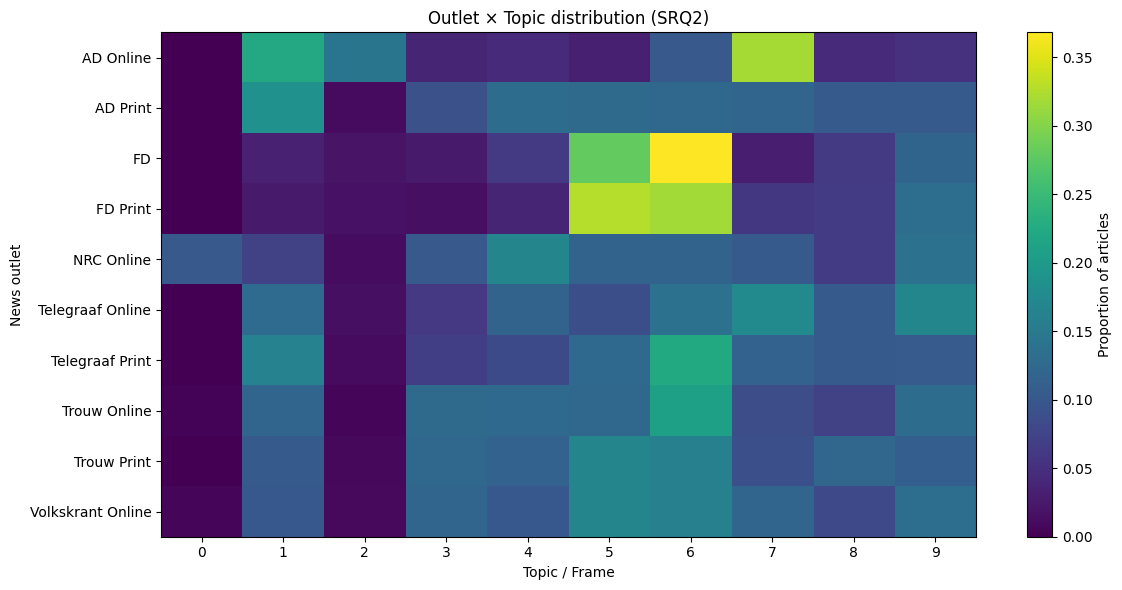

In [11]:

# 1) Outlet × Topic table (counts)
outlet_topic_counts = pd.crosstab(df["outlet"], df["topic"])

# 2) Normalize per outlet (proportions)
outlet_topic_prop = outlet_topic_counts.div(outlet_topic_counts.sum(axis=1), axis=0).fillna(0)

# 3) Heatmap (matplotlib)
plt.figure(figsize=(12, 6))
plt.imshow(outlet_topic_prop.values, aspect="auto")
plt.colorbar(label="Proportion of articles")

plt.title("Outlet × Topic distribution (SRQ2)")
plt.xlabel("Topic / Frame")
plt.ylabel("News outlet")

plt.xticks(range(outlet_topic_prop.shape[1]), outlet_topic_prop.columns)
plt.yticks(range(outlet_topic_prop.shape[0]), outlet_topic_prop.index)

plt.tight_layout()
plt.show()


Subresearch question 3

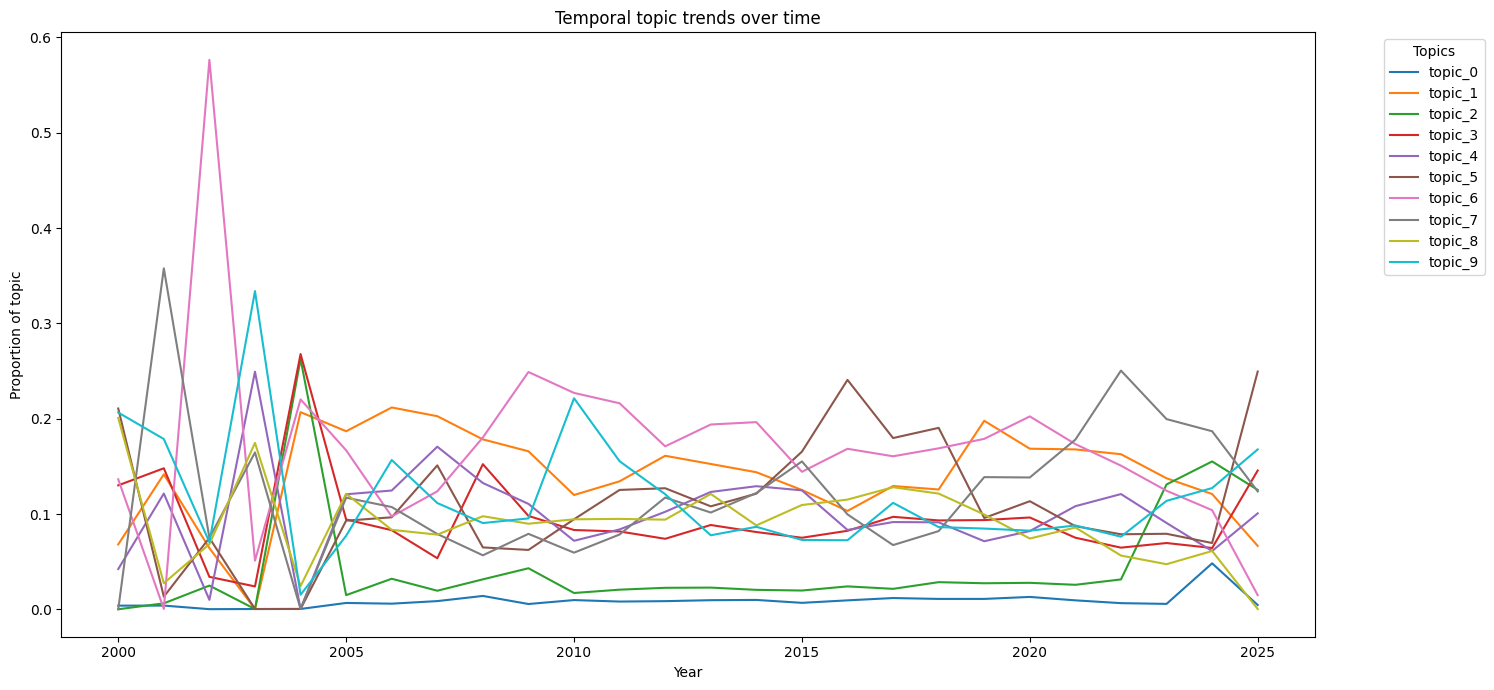

In [31]:
# 1) Topic proportions
topic_cols = [f"topic_{i}" for i in range(NUM_TOPICS)]
df_topics = pd.concat([df.reset_index(drop=True),
    pd.DataFrame(doc_topic, columns=topic_cols)],
    axis=1)


# 2) Plot temporal topic trends
plt.figure(figsize=(15, 7))

for topic in topic_cols:
    plt.plot(topic_trends.index,
        topic_trends[topic],
        label=topic)

plt.xlabel("Year")
plt.ylabel("Proportion of topic")
plt.title("Temporal topic trends over time")
plt.legend(title="Topics", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.tight_layout()
plt.show()